<a href="https://colab.research.google.com/github/chhyyi/aiffel/blob/main/LMS/LMS_NLP_node2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LMS NLP node2 프로젝트:
fundamental의 exp8에서 tokenizer를 SentencePiece로 바꿔본다.  
노드의 내용은 다음과 같다.  
>만약 이 문제에서 tokenizer를 SentencePiece로 바꾸어 다시 풀어본다면 더 성능이 좋아질까요? KoNLPy에 있는 Mecab, kkma, Okt 등과 비교해보세요.  
- 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기
- 학습된 모델로 sp_tokenize() 메소드 구현하기
- 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기
- KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
- SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기  

[해당 노드에서 내가 제출한 노트북](https://colab.research.google.com/drive/1lv3FDw2hKe_Gp56mzCxGPIHof8p0m6Cz?usp=sharing)  
일단 저 노트북을 그대로 가져와서 KoNLPy로 돌려봅시다.

In [1]:
import pandas as pd
!pip install konlpy
import konlpy
import gensim
import numpy as np
import time
from tqdm.notebook import tqdm

print(pd.__version__)
print(konlpy.__version__)
print(gensim.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 453 kB 72.1 MB/s 
1.3.5
0.6.0
3.6.0


#  tokenizer 바꾸기:
토크나이저를 변수로 해서 그냥 함수에 넣어주겠습니다. 그런데 이 과정이 꽤 오래 걸립니다. 흥미로운 점은 gpu로 바꿨는데 세션 관리에 들어가보니까 none-accelerator 세션이 살아있고, 호스팅된 런타임에 연결하니까 연결이 되고 메모리가 살아 있었단 것입니다. 물론 짧은 시간이기는 했지만요.   
아무튼 코랩 노트북이 'gpu안쓰는데 gpu 세션 왜 쓰고 있냐'고 계속 알려주면서 'gpu 많이 쓰는 사람한텐 gpu 할당 팍팍해짐'이라고 경고하는 점을 생각해보면 고민이 되는 부분입니다.     

|parser|accelerator|time|
|---|----|----|
|komoran|no|139.114|
|komoran|no|147.343|
|komoran|gpu|111.088|

일단 konlpy의 parser들이 gpu를 쓰는 것 같지는 않습니다.  

__Kkma의 에러__
이거는 이제 kkma 자체에서 메모리 누수가 심하다는 것을 보여줍니다. 이렇게 되면 20% 정도씩 잘라서 런타임을 초기화 하면서 하는 수밖에 없겠습니다. -> 그런데 알고 보니 메모리 누수가 아니라 그냥 몇 개 문장이 문제였습니다. 그래서 그냥 try 해보고 안되면 빼버리게 만들었습니다. [아무튼 한시간 넘게 돌아가는 거라서 그냥 노트북을 따로 뺐습니다.](https://colab.research.google.com/drive/1C4j1WijHjkXfhEovIDuqwAA9EAoXF9Cy?usp=sharing)
```java
27%
40555/149995 [20:29<30:22, 60.06it/s]
---------------------------------------------------------------------------
Exception                                 Traceback (most recent call last)
/usr/local/lib/python3.7/dist-packages/_jpype.cpython-37m-x86_64-linux-gnu.so in kr.lucypark.kkma.KkmaInterface.morphAnalyzer()

11 frames
Exception: Java Exception

The above exception was the direct cause of the following exception:

java.lang.OutOfMemoryError                Traceback (most recent call last)
/usr/local/lib/python3.7/dist-packages/konlpy/tag/_kkma.py in pos(self, phrase, flatten, join)
     64         validate_phrase_inputs(phrase)
     65 
---> 66         sentences = self.jki.morphAnalyzer(phrase)
     67         morphemes = []
     68         if not sentences:

java.lang.OutOfMemoryError: java.lang.OutOfMemoryError: Java heap space
```

```python
"""
This code save parsed text data, while parsing takes so long time in some parser.
It will be executed in another notebook
"""

fcsv=path+'kkma_parsed_test.csv'
data = pd.read_table(path+'ratings_test.txt')
path = '/content/drive/MyDrive/colabdata/modulabs/lms_exp8/'


def parsing(data, parser, fname):
    _=[]

    data.drop_duplicates(inplace=True)
    data.dropna(inplace=True)

    step=0

    while step<len(data['document']):
        for sent in tqdm(data['document'][step:], total=len(data['document'][step:])):
            try:
                _.append(parser.morphs(sent))
                step+=1
            except:
                print('failed to parsing row', data.index[step])
                step+=1
                break

    data['document']=_
    data.reset_index(inplace=True)
    data.to_csv(fname)

kkma=konlpy.tag.Kkma()
parsing(data, kkma, fcsv)
```

In [ ]:
fcsv=path+'kkma_parsed_test.csv'
#data = pd.read_table(path+'ratings_test.txt')
path = '/content/drive/MyDrive/colabdata/modulabs/lms_exp8/'


def parsing(data, parser, fname):
    _=[]

    data.drop_duplicates(inplace=True)
    data.dropna(inplace=True)

    step=0

    while step<len(data['document']):
        for sent in tqdm(data['document'][step:], total=len(data['document'][step:])):
            try:
                _.append(parser.morphs(sent))
                step+=1
            except:
                print('failed to parsing row', data.index[step])
                step+=1
                break

    data['document']=_
    data.reset_index(inplace=True)
    data.to_csv(fname)

#kkma=konlpy.tag.Kkma()
#parsing(data, kkma, fcsv)

In [ ]:
path='/content/drive/MyDrive/colabdata/modulabs/lms_exp8/'
train_data=pd.read_csv(path+'kkma_parsed_train_data.csv')
test_data=pd.read_csv(path+'kkma_parsed_test_data.csv')

train_data.drop(labels='Unnamed: 0', axis=1, inplace=True)
train_data

,label,document
0,0,"['아', '아', '더빙', '..', '진짜', '짜증나', '네요', '목소리']"
1,1,"['흠', '...', '포스터', '보고', '초', '딩', '영화', '줄',..."
2,0,"['너무', '재', '밓', '어', '었', '다', '그래서', '보', '는..."
3,0,"['교도소', '이야기', '구', '멀', 'ㄴ', '..', '솔직히', '재미..."
4,1,"['사이몬페그', '의', '익살', '스럽', 'ㄴ', '연기', '가', '돋보..."
...,...,...
149988,0,"['인간', '이', '문제지', '..', '소', '는', '뭔', '죄', '..."
149989,1,"['평점', '이', '너무', '낮', '아서', '...']"
149990,0,"['이것', '이', '뭐', '이', '요', '?', '한국', '인은', '거..."
149991,1,"['청춘', '영화', '의', '최고', '봉', '.', '방황', '과', '..."


In [ ]:
test_data.drop(labels='Unnamed: 0', axis=1, inplace=True)
test_data

,label,document
0,1,"['굳', 'ㅋ']"
1,0,['GDNTOPCLASSINTHECLUB']
2,0,"['뭐', '야', '이', '평점', '들', '은', '....', '나쁘', ..."
3,0,"['지루', '하', '지', '는', '않', '은데', '완전', '막장', '..."
4,0,"['3', 'D', '만', '아니', '었', '어도', '별', '다섯', '개..."
...,...,...
49989,1,"['오랜만', '에', '평점', '로', '긴하', '었', '네', 'ㅋㅋ', ..."
49990,0,"['의지', '박약', '들', '이나', '하', '는', '거', '이', '다..."
49991,0,"['그림', '도', '좋', '고', '완성도', '도', '높', '았', '지..."
49992,0,"['절대', '보', '아서', '는', '안', '되', 'ㄹ', '영화', '...."


In [5]:
num_words=10000
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def tokenizer(train, test, num_words=num_words):

    train_idx=[]
    test_idx=[]
    
    dict_last_index=0

    appearance={"<PAD>":100,"<BOS>":100, "<UNK>":100}
    #appearance: 전체 데이터에서 등장 횟수.
    #인덱스는 그냥 word로 하겠습니다.
    
    #word to_index, index_to_word 초기화.
    word_to_index={"<PAD>":0, "<BOS>":1, "<UNK>":2}
    index_to_word={0:"<PAD>", 1:"<BOS>", 2:"<UNK>"}

    for tokens in train_data.document:
        
        token_to_index=[]
        
        for tk in tokens:
            if tk not in stopwords:
                if tk in word_to_index.keys():
                    token_to_index.append(word_to_index[tk])
                    appearance[tk]+=1

                else:
                    index_to_word[dict_last_index]=tk
                    word_to_index[tk]=dict_last_index
                    dict_last_index+=1
                    token_to_index.append(word_to_index[tk])
                    appearance[tk]=1

        train_idx.append(token_to_index)

    for tokens in test.document:
        token_to_index=[]
        for tk in tokens:
            if tk not in stopwords:
                if tk in word_to_index.keys():
                    token_to_index.append(word_to_index[tk])
                    appearance[tk]+=1
                else:
                    index_to_word[dict_last_index]=tk
                    word_to_index[tk]=dict_last_index
                    dict_last_index+=1
                    token_to_index.append(word_to_index[tk])
                    appearance[tk]=1

        test_idx.append(token_to_index)
    
    if len(index_to_word)>num_words:
        min=np.min(appearance.values())
        for word, index in word_to_index.items():
            if appearance[word]==min:
                del word_to_index[word] 
                del index_to_word[index]
            if len(index_to_word)<num_words:
                break
    
    
    for i, sentence in enumerate(test_idx):
        for j, token in enumerate(sentence):
            if token not in index_to_word.keys():
                test_idx[i,j]=word_to_index["<UNK>"]
    for i, sentence in enumerate(train_idx):
        for j, token in enumerate(sentence):
            if token not in index_to_word.keys():
                train_idx[i,j]=word_to_index["<UNK>"]

        
    return train_idx, train.label, test_idx, test.label, word_to_index, index_to_word

#index_to_word도 tokenizer에서 만들었기 때문에 그냥 같이 반환합니다.
X_train, y_train, X_test, y_test, word_to_index, index_to_word = tokenizer(train_data, test_data)
print(X_train[:5])

[[0, 1, 2, 1, 3, 4, 1, 5, 6, 1, 3, 4, 1, 7, 1, 3, 4, 1, 7, 1, 3, 4, 1, 8, 9, 1, 3, 4, 1, 9, 10, 1, 3, 4, 1, 11, 1, 3, 4, 1, 12, 13, 1, 3, 4, 1, 14, 15, 16, 1, 17], [0, 1, 18, 1, 3, 4, 1, 7, 7, 7, 1, 3, 4, 1, 19, 20, 21, 1, 3, 4, 1, 22, 23, 1, 3, 4, 1, 24, 25, 1, 3, 4, 1, 26, 27, 1, 3, 4, 1, 28, 1, 3, 4, 1, 7, 7, 7, 7, 1, 3, 4, 1, 29, 30, 1, 3, 4, 1, 31, 32, 1, 3, 4, 1, 33, 34, 1, 3, 4, 1, 35, 1, 3, 4, 1, 36, 1, 3, 4, 1, 37, 1, 3, 4, 1, 38, 11, 1, 17], [0, 1, 39, 40, 41, 42, 43, 44, 45, 46, 47, 22, 48, 49, 50, 51, 44, 1, 17], [0, 1, 52, 15, 1, 3, 4, 1, 53, 32, 1, 3, 4, 1, 1, 3, 4, 1, 38, 54, 1, 3, 4, 1, 7, 7, 1, 3, 4, 1, 55, 56, 57, 1, 3, 4, 1, 41, 58, 1, 3, 4, 1, 1, 3, 4, 1, 59, 1, 3, 4, 1, 44, 1, 3, 4, 1, 7, 1, 3, 4, 1, 7, 1, 3, 4, 1, 60, 61, 1, 3, 4, 1, 33, 62, 1, 17], [0, 1, 63, 64, 65, 45, 1, 3, 4, 1, 66, 67, 1, 3, 4, 1, 20, 68, 1, 3, 4, 1, 69, 1, 3, 4, 1, 31, 32, 1, 3, 4, 1, 1, 3, 4, 1, 70, 22, 1, 3, 4, 1, 43, 1, 3, 4, 1, 71, 1, 3, 4, 1, 26, 27, 1, 3, 4, 1, 72, 1, 3, 4, 1, 20, 73,

In [ ]:
len(word_to_index), len(index_to_word)

(3097, 3094)

# save & load parsed data

In [6]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [ ]:
get_decoded_sentence(X_train[0], index_to_word)


"' 아 ' ,   ' 아 ' ,   ' 더 빙 ' ,   ' . . ' ,   ' 진 짜 ' ,   ' 짜 증 나 ' ,   ' 네 요 ' ,   ' 목 소 리 ' ]"

In [ ]:
length=[len(sentence) for sentence in X_train]
print(np.max(length), np.mean(length), np.std(length))
maxlen=int(np.mean(length)+2*np.std(length))

692 105.71086650710366 87.89572050494313


In [ ]:
print(maxlen)

281


In [ ]:
import tensorflow as tf
x_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(x_train.shape)

(149993, 281)


In [ ]:
print(x_test.shape, x_train.shape)

(49994, 281) (149993, 281)


In [ ]:
vocab_size = len(word_to_index)+1
word_vector_dim = 32  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(32))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, None, 32)          99136     
                                                                 
 lstm_19 (LSTM)              (None, 32)                8320      
                                                                 
 dense_20 (Dense)            (None, 32)                1056      
                                                                 
 dense_21 (Dense)            (None, 1)                 33        
                                                                 
Total params: 108,545
Trainable params: 108,545
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=20 

history = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_test, y_test), verbose=1)

Epoch 1/20
293/293 [==============================] - 10s 28ms/step - loss: 0.5185 - accuracy: 0.7431 - val_loss: 0.4603 - val_accuracy: 0.7856
Epoch 2/20
293/293 [==============================] - 8s 27ms/step - loss: 0.4460 - accuracy: 0.7941 - val_loss: 0.4489 - val_accuracy: 0.7899
Epoch 3/20
293/293 [==============================] - 8s 27ms/step - loss: 0.4301 - accuracy: 0.8003 - val_loss: 0.4373 - val_accuracy: 0.7935
Epoch 4/20
293/293 [==============================] - 8s 29ms/step - loss: 0.4154 - accuracy: 0.8073 - val_loss: 0.4197 - val_accuracy: 0.8052
Epoch 5/20
293/293 [==============================] - 8s 27ms/step - loss: 0.4012 - accuracy: 0.8149 - val_loss: 0.4147 - val_accuracy: 0.8082
Epoch 6/20
293/293 [==============================] - 8s 27ms/step - loss: 0.3934 - accuracy: 0.8202 - val_loss: 0.4075 - val_accuracy: 0.8124
Epoch 7/20
293/293 [==============================] - 8s 27ms/step - loss: 0.3868 - accuracy: 0.8248 - val_loss: 0.4038 - val_accuracy: 0.814

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


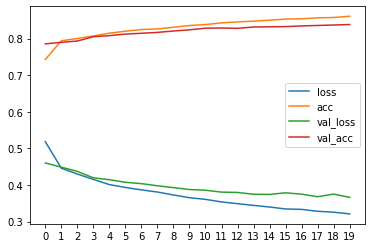

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['val_accuracy'], label='val_acc')

plt.legend()
plt.xticks(ticks=list(range(20)))
plt.show()

# kkma 형태소 분석기 적용 결과:
같은 10000 words인데 val_loss가 천천히 올라갑니다. 근데 accuracy가 딱히 높지는 않습니다. training을 더 시켜볼까요?

Epoch 1/20
293/293 [==============================] - 10s 28ms/step - loss: 0.3194 - accuracy: 0.8619 - val_loss: 0.3660 - val_accuracy: 0.8396
Epoch 2/20
293/293 [==============================] - 8s 26ms/step - loss: 0.3146 - accuracy: 0.8642 - val_loss: 0.3731 - val_accuracy: 0.8347
Epoch 3/20
293/293 [==============================] - 8s 26ms/step - loss: 0.3118 - accuracy: 0.8658 - val_loss: 0.3740 - val_accuracy: 0.8391
Epoch 4/20
293/293 [==============================] - 8s 26ms/step - loss: 0.3103 - accuracy: 0.8667 - val_loss: 0.3767 - val_accuracy: 0.8369
Epoch 5/20
293/293 [==============================] - 8s 26ms/step - loss: 0.3059 - accuracy: 0.8689 - val_loss: 0.3677 - val_accuracy: 0.8382
Epoch 6/20
293/293 [==============================] - 8s 26ms/step - loss: 0.3020 - accuracy: 0.8708 - val_loss: 0.3731 - val_accuracy: 0.8363
Epoch 7/20
293/293 [==============================] - 8s 26ms/step - loss: 0.3012 - accuracy: 0.8717 - val_loss: 0.3635 - val_accuracy: 0.841

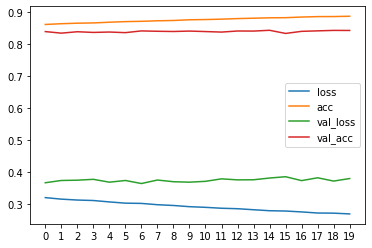

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=20 

history = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_valid, y_valid), verbose=1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['val_accuracy'], label='val_acc')

plt.legend()
plt.xticks(ticks=list(range(20)))
plt.show()

# Komoran 형태소 분석기 적용 결과:


In [3]:
path='/content/drive/MyDrive/colabdata/modulabs/lms_exp8/'
train_data=pd.read_csv(path+'Komoran_parsed_train.csv')
test_data=pd.read_csv(path+'Komoran_parsed_test.csv')

In [ ]:
X_train, y_train, X_test, y_test, word_to_index, index_to_word = tokenizer(train_data, test_data)

In [9]:
length=[len(sentence) for sentence in X_train]
print(np.max(length), np.mean(length), np.std(length))
maxlen=int(np.mean(length)+2*np.std(length))

print('maxlength is: ',maxlen)

700 102.62062735424514 85.9458426226767
maxlength is:  274


In [11]:
import tensorflow as tf
x_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(x_train.shape, x_test.shape)

(149995, 274) (49997, 274)


In [17]:
vocab_size = len(word_to_index)+1
word_vector_dim = 32  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(32))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          101408    
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 110,817
Trainable params: 110,817
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=40

history = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_test, y_test), verbose=1)

Epoch 1/40
293/293 [==============================] - 10s 29ms/step - loss: 0.5184 - accuracy: 0.7396 - val_loss: 0.4725 - val_accuracy: 0.7806
Epoch 2/40
293/293 [==============================] - 8s 26ms/step - loss: 0.4482 - accuracy: 0.7939 - val_loss: 0.4502 - val_accuracy: 0.7906
Epoch 3/40
293/293 [==============================] - 8s 26ms/step - loss: 0.4365 - accuracy: 0.7990 - val_loss: 0.4402 - val_accuracy: 0.7938
Epoch 4/40
293/293 [==============================] - 8s 26ms/step - loss: 0.4242 - accuracy: 0.8050 - val_loss: 0.4305 - val_accuracy: 0.7975
Epoch 5/40
293/293 [==============================] - 8s 26ms/step - loss: 0.4116 - accuracy: 0.8112 - val_loss: 0.4181 - val_accuracy: 0.8064
Epoch 6/40
293/293 [==============================] - 8s 26ms/step - loss: 0.3979 - accuracy: 0.8179 - val_loss: 0.4141 - val_accuracy: 0.8082
Epoch 7/40
293/293 [==============================] - 8s 26ms/step - loss: 0.3916 - accuracy: 0.8222 - val_loss: 0.4082 - val_accuracy: 0.812

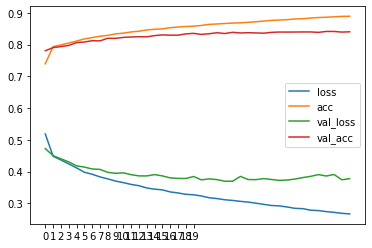

In [19]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['val_accuracy'], label='val_acc')

plt.legend()
plt.xticks(ticks=list(range(40)))
plt.show()

In [22]:
len(word_to_index), len(index_to_word)

(3168, 3165)

In [ ]:
# Okt 형태소 분석기 적용 결과

# SentencePiece 사용해보기
__(여기서부터 독립적으로 실행 가능하게 만듭시다)__  
같은 작업을 SentencePiece를 이용해서 다시 해보라고 하였는데, 이게 어떤 일인지 생각해봅니다. 
1. SentencePiece 훈련 데이터가 그것을 적용할 데이터와 같은데 상관 없는가?: test data와 제대로 분리된다면 상관 없겠다. 물론 다른 데이터로 훈련하면 더 좋을지는 알 수 없다.
2. 

In [ ]:
!pip install konlpy
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import konlpy
import os


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 533 kB/s 
     |████████████████████████████████| 453 kB 67.8 MB/s 


In [ ]:
#!wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
#!tar -xzvf /content/drive/MyDrive/colabdata/modulabs/lms_exp8/data/korean-english-park.train.tar.gz
#!mv korean-english-park.train.en /content/drive/MyDrive/colabdata/modulabs/lms_exp8/data/korean-english-park.train.en
#!mv korean-english-park.train.ko /content/drive/MyDrive/colabdata/modulabs/lms_exp8/data/korean-english-park.train.ko

min_len: 1, max_len: 146


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


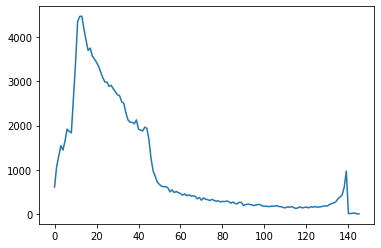

In [ ]:
import pandas as pd
#path_to_file = path+'data/korean-english-park.train.ko'
path = '/content/drive/MyDrive/colabdata/modulabs/lms_exp8/'
min_len=10000
sum_len=0
max_len=0

raw = pd.read_table(path+'ratings_train.txt')['document'].tolist()

for sen in raw:
    length = len(str(sen))
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print('min_len: {}, max_len: {}'.format(min_len, max_len))
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in raw:
    sentence_length[len(str(sen))-1] += 1

plt.plot(sentence_length)
plt.show()


In [ ]:

cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.

min_len=10000
sum_len=0
max_len=0

for sen in cleaned_corpus:
    length = len(str(sen))
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))


문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


In [ ]:
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(str(sen))-1] += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


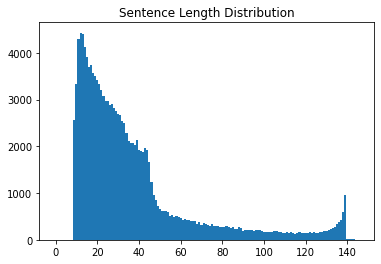

In [ ]:
max_len = 146
min_len = 10

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if type(s)==str if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [ ]:
!pip install sentencepiece

import sentencepiece as spm

temp_file = path+'korean-english-park.train.ko.temp'

vocab_size = 10000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train("--input={} --model_prefix=korean_spm --vocab_size={} ".format(temp_file, vocab_size))
#spm.SentencePieceTrainer.Train("--input={} --model_type=bpe --model_prefix=korean_spm --vocab_size={} ".format(temp_file, vocab_size))
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 7.8 MB/s 
-rw-r--r-- 1 root root 413864 Sep 26 05:02 korean_spm.model
-rw-r--r-- 1 root root 185074 Sep 26 05:02 korean_spm.vocab


In [ ]:
!mv korean_spm.model /content/drive/MyDrive/colabdata/modulabs/lms_exp8/data/korean_spm.model
!mv korean_spm.vocab /content/drive/MyDrive/colabdata/modulabs/lms_exp8/data/korean_spm.vocab

In [ ]:
s = spm.SentencePieceProcessor()
s.Load(path+'data/korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.', -1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1270, 10, 434, 15, 1299, 10, 155, 18, 4]
['▁아버지', '가', '방', '에', '들', '어', '가', '신', '다', '.']
아버지가방에들어가신다.


In [ ]:
def sp_tokenize(s, corpus, maxlen):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open(path+"data/korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre', maxlen=maxlen)

    return tensor, word_index, index_word

def sp_tokenize_test(s, corpus, maxlen):
    tensor=[]
    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre', maxlen=maxlen)
    return tensor

## sp_tokenize의 수정:  
padding을 'post'에서 'pre'로 바꾼 것 말고는 별로 차이가 없습니다.  
sp_tokenize_test() 함수는 그냥 인코딩만 하고 word_index, index_word는 건드리지 않습니다. 어차피 sp_tokenize에서 korean_spm.vocab의 모든 단어를 꺼내어 저장했기 때문에 다시 할 필요가 없습니다.

In [ ]:
train_data=pd.read_table(path+'ratings_train.txt')
test_data=pd.read_table(path+'ratings_test.txt')
train_data.drop_duplicates(inplace=True)
train_data.dropna(inplace=True)
test_data.drop_duplicates(inplace=True)
test_data.dropna(inplace=True)

In [ ]:
#sp_tokenize(s, corpus) 사용예제
maxlen=146
tensor, word_index, index_word = sp_tokenize(s, train_data['document'], maxlen)

In [ ]:
X_train=tensor
X_test=sp_tokenize_test(s, test_data['document'], maxlen)
y_train=train_data['label'].to_numpy()
y_test=test_data['label'].to_numpy()

In [ ]:
len(index_word)

10000

In [ ]:
#s.pad_id()
#index_word[10000]='<PAD>'
#word_index['<PAD>']=10000

In [ ]:
print(X_test.shape, X_train.shape)

(49997, 146) (149995, 146)


In [ ]:
vocab_size = len(word_index)
word_vector_dim = 32  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
#model.add(tf.keras.layers.LSTM(128, return_sequences=True))
#to stack LSTM layers, return_sequences should be True except the last layer, as output of default LSTM layer reduces dimension by 1
model.add(tf.keras.layers.LSTM(32))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, None, 32)          320000    
                                                                 
 lstm_22 (LSTM)              (None, 32)                8320      
                                                                 
 dense_26 (Dense)            (None, 32)                1056      
                                                                 
 dense_27 (Dense)            (None, 1)                 33        
                                                                 
Total params: 329,409
Trainable params: 329,409
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=20

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_test, y_test), verbose=1)

Epoch 1/20
293/293 [==============================] - 7s 17ms/step - loss: 0.4273 - accuracy: 0.8044 - val_loss: 0.3629 - val_accuracy: 0.8431
Epoch 2/20
293/293 [==============================] - 5s 16ms/step - loss: 0.3096 - accuracy: 0.8690 - val_loss: 0.3347 - val_accuracy: 0.8535
Epoch 3/20
293/293 [==============================] - 5s 16ms/step - loss: 0.2840 - accuracy: 0.8812 - val_loss: 0.3347 - val_accuracy: 0.8528
Epoch 4/20
293/293 [==============================] - 5s 16ms/step - loss: 0.2643 - accuracy: 0.8902 - val_loss: 0.3456 - val_accuracy: 0.8516
Epoch 5/20
293/293 [==============================] - 5s 16ms/step - loss: 0.2473 - accuracy: 0.8971 - val_loss: 0.3516 - val_accuracy: 0.8501
Epoch 6/20
293/293 [==============================] - 5s 16ms/step - loss: 0.2317 - accuracy: 0.9036 - val_loss: 0.3622 - val_accuracy: 0.8491
Epoch 7/20
293/293 [==============================] - 5s 16ms/step - loss: 0.2183 - accuracy: 0.9089 - val_loss: 0.3820 - val_accuracy: 0.8472

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


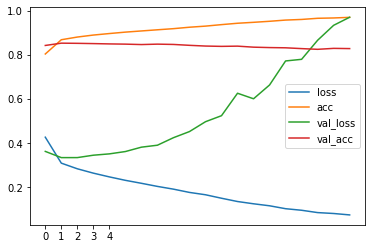

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['val_accuracy'], label='val_acc')

plt.legend()
plt.xticks(ticks=list(range(5)))
plt.show()

In [ ]:
model.predict([s.EncodeAsIds('돈 주고 보기 아깝다'),])

array([[2.2169974e-08]], dtype=float32)

In [ ]:
model.predict([s.EncodeAsIds('연기가 어중간하다.')])

array([[0.962828]], dtype=float32)

In [ ]:
model.predict([s.EncodeAsIds('재미 없지는 않은데 예전이 더 좋았다.')])

array([[0.5373337]], dtype=float32)

In [ ]:
model.predict([s.EncodeAsIds('정말 실망스러웠지만 전투 장면 연출만큼은 좋았다')])

array([[0.94696575]], dtype=float32)

In [ ]:
model.predict([s.EncodeAsIds('다 좋았는데 마지막 장면은 정말 억지였다.')])

array([[0.00598774]], dtype=float32)

# 결과, 돌아보기  
SentencePiece를 학습시키고, 그것으로 tokenize해서 감정 분류기를 학습시키는데 성공하였다. 그 성능은 형태소분석기로 Kkma를 썼을 때보다 조금 좋았지만, 학습 속도는 훨씬 빨랐다. 하지만 형태소분석기는 같은 training data에 대해 단어장의 사이즈가 훨씬 작았기 때문에 훨씬 적은 parameter를 사용하였다.  

둘 모두 32 neuron을 가지는 LSTM Layer 하나에 FC layer를 연결해서 사용했다.

|Parser|vocab_size|training_time(total)|parameters|epoch|val_acc|
|----|----|----|----|----|----|
|SentencePiece|10000|143.601|329,409|20|0.8289|
|SentencePiece|10000||329,409|2|0.8535|
|Kkma|3097|203.919|108,545|20|0.8385|
|Komoran|3165|305.517|110,817|40|0.8405|